## Import pakietów


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf
from scipy.linalg import eigh
from numpy.linalg import norm

## Funkcje

In [2]:
def generate_constant_covariance(p):
    """Generuje jednostkową macierz kowariancji"""
    return np.eye(p)

def sample_covariance(X):
    """Zwraca próbkową macierz kowariancji"""
    n = X.shape[0]
    mean = np.mean(X, axis=0)
    centered_X = X - mean
    cov_matrix = np.dot(centered_X.T, centered_X) / n
    return cov_matrix

def thresholding_estimator(S, t):
    """Zwraca estymator progowy macierzy kowariancji"""
    return np.where(np.abs(S) > t, S, 0)

def thresholding_cv(X, p, n, s_vals, N, random_state=None, prnt=False):
    """Metoda doboru progu za pomocą walidacji krzyżowej"""
    rng = np.random.default_rng(random_state)
    n1 = int(n * (1 - 1 / np.log(n)))
    R_s_values = []

    for s in s_vals:
        total = 0
        for _ in range(N):
            indices = rng.permutation(n)
            X1, X2 = X[indices[:n1]], X[indices[n1:]]
            S1 = sample_covariance(X1)
            S2 = sample_covariance(X2)
            T = thresholding_estimator(S1, s)
            total += norm(T - S2, 'fro') ** 2
        R_s = total / N
        R_s_values.append((s, R_s))

    optimal_s = min(R_s_values, key=lambda x: x[1])[0]
    if prnt:
        print(f"Optimal CV threshold for {p} is {optimal_s}.")
    return optimal_s

def evaluate_estimators(Sigma_true, Sigma_est):
    '''Zwraca odpowiednie normy'''
    fro_norm = norm(Sigma_true - Sigma_est, 'fro')
    one_norm = norm(Sigma_true - Sigma_est, 1)
    operator_norm = norm(Sigma_true - Sigma_est, 2)
    return fro_norm, one_norm, operator_norm

def plot_eigenvalues(Sigma_true, results, p, n, save_path=None):
    '''Rysunek'''
    eigvals_true = eigh(Sigma_true)[0][::-1]
    plt.plot(eigvals_true, label='True', color='black')

    for method, est_matrices in results.items():
        eigvals_est = np.mean([eigh(S)[0][::-1] for S in est_matrices], axis=0)
        plt.plot(eigvals_est, label=f'{method.capitalize()}', linestyle='--')

    plt.xlabel('Indeks wartości własnej')

    # Formatowanie tytułu
    ratio = p / n
    ratio_str = f"{ratio:.1f}" if not ratio.is_integer() else f"{int(ratio)}"
    plt.title(f'$p/n = {ratio_str}$')
    
    if save_path:
        plt.savefig(save_path, format='svg', bbox_inches='tight')

    plt.show()

def run_experiment(p,n, N, n_replicates):
    results = {"sample": [], "thresholding_cv": []}
    param_results = {"thresholding_cv": []}

    for _ in range(n_replicates):
        true_cov = generate_constant_covariance(p)
        X = np.random.multivariate_normal(np.zeros(p), true_cov, n)

        s_vals = np.linspace(0.01, 1, 100)

        S = sample_covariance(X)
        results["sample"].append(S)
        
        optimal_t = thresholding_cv(X, p, n, s_vals, N)
        param_results["thresholding_cv"].append(optimal_t)
        thresholded_S_cv = thresholding_estimator(S, optimal_t)
        results["thresholding_cv"].append(thresholded_S_cv)

    return results, param_results


## Symulacje dla macierzy jednostkowej

Wyniki dla p = 10
         Metoda Norma Frobeniusa    Norma 1    Norma 2
         sample       1.04(0.01) 1.18(0.02) 0.60(0.01)
thresholding_cv       0.45(0.01) 0.28(0.01) 0.28(0.01)
Średnie wartości dobranych parametrów:
         Metoda Wartość parametru
thresholding_cv        0.51(0.01)


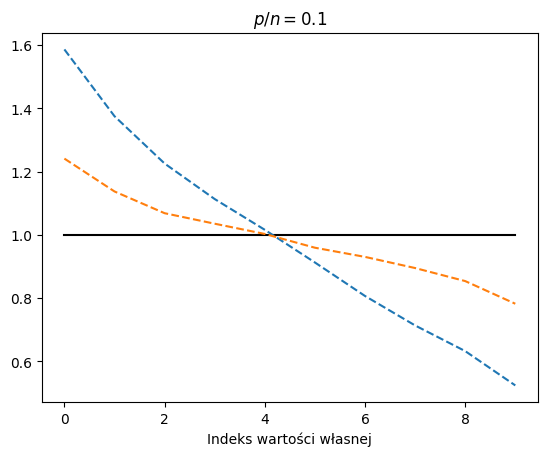

Wyniki dla p = 50
         Metoda Norma Frobeniusa    Norma 1    Norma 2
         sample       5.02(0.01) 5.27(0.04) 1.74(0.01)
thresholding_cv       1.01(0.01) 0.39(0.01) 0.39(0.01)
Średnie wartości dobranych parametrów:
         Metoda Wartość parametru
thresholding_cv        0.50(0.01)


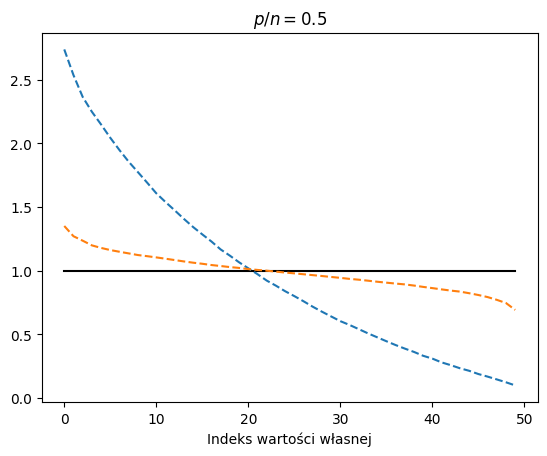

Wyniki dla p = 100
         Metoda Norma Frobeniusa     Norma 1    Norma 2
         sample      10.03(0.02) 10.28(0.05) 2.86(0.02)
thresholding_cv       1.49(0.02)  0.51(0.02) 0.50(0.02)
Średnie wartości dobranych parametrów:
         Metoda Wartość parametru
thresholding_cv        0.54(0.01)


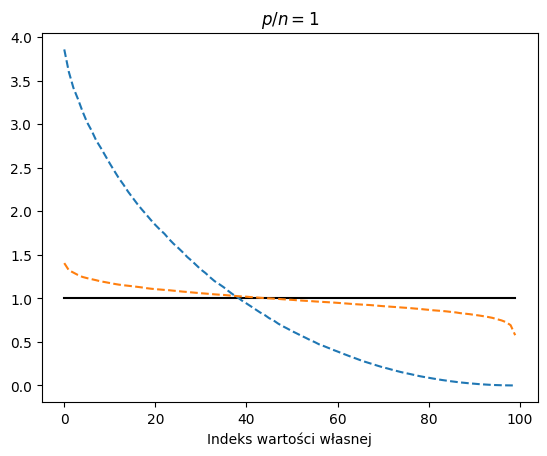

Wyniki dla p = 500
         Metoda Norma Frobeniusa     Norma 1    Norma 2
         sample      49.79(0.03) 49.67(0.12) 9.18(0.02)
thresholding_cv       3.32(0.04)  0.64(0.02) 0.62(0.02)
Średnie wartości dobranych parametrów:
         Metoda Wartość parametru
thresholding_cv        0.54(0.01)


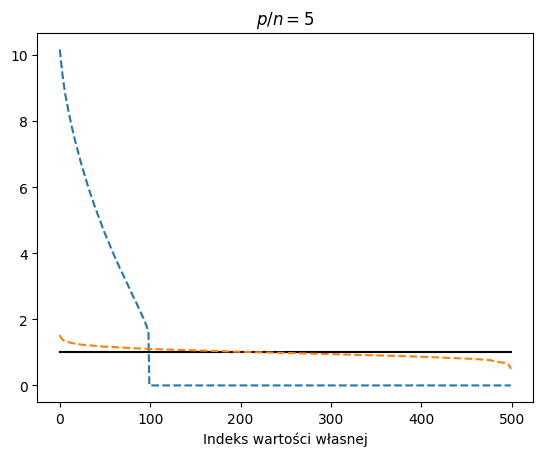

In [3]:
np.random.seed(42)
p_values = [10, 50, 100,500]
n = 100
N = 50
n_replicates = 50

for p in p_values:
    results, param_results = run_experiment(p,n, N, n_replicates)

    data = []
    for method, est_matrices in results.items():
        fro_norms, one_norms, op_norms = [], [], []
        for est_matrix in est_matrices:
            fro, one, op, = evaluate_estimators(generate_constant_covariance(p), est_matrix)
            fro_norms.append(fro)   
            one_norms.append(one)
            op_norms.append(op)
        
        data.append([
            method,
            f"{np.mean(fro_norms):.2f}({np.std(fro_norms) / np.sqrt(n):.2f})",
            f"{np.mean(one_norms):.2f}({np.std(one_norms) / np.sqrt(n):.2f})",
            f"{np.mean(op_norms):.2f}({np.std(op_norms) / np.sqrt(n):.2f})",
        ])

    columns = ['Metoda', 'Norma Frobeniusa', 'Norma 1', 'Norma 2']
    df = pd.DataFrame(data, columns=columns)
    print(f"Wyniki dla p = {p}")
    print(df.to_string(index=False))

    param_data = []
    for method, params in param_results.items():
        param_data.append([
            method,
            f"{np.mean(params):.2f}({np.std(params) / np.sqrt(n):.2f})"
        ])

    param_df = pd.DataFrame(param_data, columns=['Metoda', 'Wartość parametru'])
    print("Średnie wartości dobranych parametrów:")
    print(param_df.to_string(index=False))

    plot_eigenvalues(generate_constant_covariance(p), results, p, n, save_path=False)
